## Содежржание

[Библиотеки](#libraries)

[1. Данные](#data)

[2. Простые классификаторы](#simple_classifiers)

[3. Метрические классификаторы на базе новой модели](#metric_classifiers_new_model)

[4. Метрические классификаторы на базе новой модели с разделением базы признаковых описаний](#metric_classifiers_new_model_splited)

[5. Метрические классификаторы на базе старой модели](#metric_classifiers_old_model)

[6. Метрические классификаторы на базе новой модели с разделением базы признаковых описаний](#metric_classifiers_old_model_splited)

[7. Сравнение результатов моделей](#results_comparison)

[8. Определение итоговой модели](#final_model)

[9. Заключение](#conclusion)

<a id='libraries'></a>
## Библиотеки

In [1]:
import os
from collections import OrderedDict
import torch

import dataset.custom_datasets as cust_ds
import dataset.default_augmentations as def_augs
from tools.feature_base import FeaturesBase
from tools.vectorizer import Vectorizer

from models.triplet_loss import ClassificationForTLModel
from models.triplet_loss import TripletLossModel, TripletLossFeaturesModel
from models.triplet_loss_old import TL_005_concatenate, TripletLossModelOld
from models.triplet_loss_old import conv_simple_features_00
from models.triplet_loss_old import fully_connect_modul_265

from models.triplet_loss import ClassificationForTLModel
import models.metric_tl_classifier as metr_tl_cl

from model_selection.metrics import CustomAccuracy, F1Score
from model_test.metric_model_test import test_classification
from model_test.metric_model_test import test_classification_splited
from model_test.metric_model_test import test_classification_joint

<a id='data'></a>
## 1. Данные

**Данные для классификаторов**

In [2]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
test_ds_path = os.path.join(datasets_path, 'sampled_test')

In [3]:
def marks_indx_f(x):
    return (x[0],)


def models_indx_f(x):
    return (x[0], x[1])

In [4]:
classif_ds_test_marks = cust_ds.TLClassifyDataset(
    test_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_test_augs_128
)

classif_ds_test_models = cust_ds.TLClassifyDataset(
    test_ds_path, models_indx_f, crop=False,
    transform=def_augs.clTL_train_augs_128
)

**База признаковых описаний**

In [5]:
total_features_len = 196
features_base = FeaturesBase(total_features_len)

base_filepaths = [
    'csv/train/data_marks_train.csv',
    'csv/train/data_models_train.csv',
    'csv/train/data_all_train.csv'
]

features_base.load_base(base_filepaths)

<a id='simple_classifiers'></a>
## 2. Простые классификаторы

В данной работе простые классификаторы являются baseline моделями. Целью построения более сложных моделей является превышение порога качества классификации, которое показывают простые классификаторы.

**Марки**

In [27]:
mark_classes_n = len(classif_ds_test_marks.labels_code)
class_mark_model = ClassificationForTLModel(mark_classes_n)

In [28]:
w_filepaths_marks_load = [
    'weights/1. classify for triplet loss - marks/900 epochs/conv2Dfeatures.pt',
    'weights/1. classify for triplet loss - marks/900 epochs/fully_connect.pt'
]

class_mark_model.split_load(w_filepaths_marks_load)

In [29]:
acc_class_marks = CustomAccuracy()
acc_class_marks_res = acc_class_marks.ds_scope(classif_ds_test_marks,
                                               class_mark_model)
print(f'Accuracy модели классификации марок: {round(acc_class_marks_res, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

Accuracy модели классификации марок: 0.569


In [30]:
f1_class_marks = F1Score()
f1_class_marks_res = f1_class_marks.ds_scope(classif_ds_test_marks,
                                             class_mark_model)
print(f'f1 score модели классификации марок: {round(f1_class_marks_res, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

f1 score модели классификации марок: 0.474


**Модели**

In [31]:
models_classes_n = len(classif_ds_test_models.labels_code)
class_models_model = ClassificationForTLModel(models_classes_n)

In [32]:
w_filepaths_models_load = [
    'weights/3. classify for triplet loss - models/1. 1103 epochs/conv2Dfeatures.pt',
    'weights/3. classify for triplet loss - models/1. 1103 epochs/fully_connect.pt'
]

class_models_model.split_load(w_filepaths_models_load)

In [33]:
acc_class_models = CustomAccuracy()
acc_class_models_res = acc_class_models.ds_scope(classif_ds_test_models,
                                                 class_models_model)
print(f'Accuracy модели классификации марок: {round(acc_class_models_res, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

Accuracy модели классификации марок: 0.399


In [34]:
f1_class_models = F1Score()
f1_class_models_res = f1_class_models.ds_scope(classif_ds_test_models,
                                               class_models_model)
print(f'f1 score модели классификации марок: {round(f1_class_models_res, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

f1 score модели классификации марок: 0.317


<a id='metric_classifiers_new_model'></a>
## 3. Метрические классификаторы на базе новой модели

Под новой моделью имеется в виду модель, обученная на некропнутых изображениях автомобилей. Под кропом изображения автомобиля подразумевается вырез области автомобиля вокруг марки.

**Общая Triplet Loss модель**

In [6]:
marks_features_len = 128
tl_mark_model = TripletLossModel(marks_features_len)

weights_marks_p = [
    'weights/2. triplet loss model - marks/3. 1154 epochs/conv2Dfeatures_best_var.pt',
    'weights/2. triplet loss model - marks/3. 1154 epochs/fully_connect_best_var.pt'
]

tl_mark_model.split_load(weights_marks_p)

In [7]:
models_features_len = 64
tl_models_model = TripletLossModel(models_features_len)

weights_models_p = [
    'weights/4. triplet loss model - models/2. 456 epochs/conv2Dfeatures_best_var.pt',
    'weights/4. triplet loss model - models/2. 456 epochs/fully_connect_best_var.pt'
]

tl_models_model.split_load(weights_models_p)

In [8]:
total_features_len = marks_features_len + models_features_len
cat_tl_model = TripletLossFeaturesModel(total_features_len,
                                        tl_mark_model, tl_models_model)

**Метрические модели классификации**

Базовые метрические модели:

In [21]:
knn_marks_model = metr_tl_cl.MarkskNN(features_base)
knn_marks_model.set_knn()

knn_models_model = metr_tl_cl.ModelskNN(features_base)
knn_models_model.set_knn()

mah_marks_model = metr_tl_cl.MarksMah(features_base)
mah_marks_model.set_mah()

mah_models_model = metr_tl_cl.ModelsMah(features_base)
mah_models_model.set_mah()

Комбинации базовых моделей:

In [22]:
knn_knn_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     knn_models_model)

knn_mah_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     mah_models_model)

mah_knn_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     knn_models_model)

mah_mah_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     mah_models_model)

**Оценка качества**

In [23]:
res0 = test_classification(test_ds_path, cat_tl_model, knn_knn_model)
print('Результаты knn + knn:')
print(f'marks acc: {round(res0[0], 3)}')
print(f'models acc: {round(res0[1], 3)}')
print(f'marks f1: {round(res0[2], 3)}')
print(f'models f1: {round(res0[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + knn:
marks acc: 0.648
models acc: 0.063
marks f1: 0.653
models f1: 0.049


In [24]:
res1 = test_classification(test_ds_path, cat_tl_model, knn_mah_model)
print('Результаты knn + mah:')
print(f'marks acc: {round(res1[0], 3)}')
print(f'models acc: {round(res1[1], 3)}')
print(f'marks f1: {round(res1[2], 3)}')
print(f'models f1: {round(res1[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

C:\Users\ski6a\Desktop\Junior ML Contest\src\models\metric_tl_classifier.py:34: RuntimeWarning: invalid value encountered in sqrt
  d = np.sqrt(np.einsum('ij,ji->i', a, b))


Результаты knn + mah:
marks acc: 0.648
models acc: 0.036
marks f1: 0.653
models f1: 0.014


In [25]:
res2 = test_classification(test_ds_path, cat_tl_model, mah_knn_model)
print('Результаты mah + knn:')
print(f'marks acc: {round(res2[0], 3)}')
print(f'models acc: {round(res2[1], 3)}')
print(f'marks f1: {round(res2[2], 3)}')
print(f'models f1: {round(res2[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + knn:
marks acc: 0.643
models acc: 0.064
marks f1: 0.656
models f1: 0.048


In [26]:
res3 = test_classification(test_ds_path, cat_tl_model, mah_mah_model)
print('Результаты mah + mah:')
print(f'marks acc: {round(res3[0], 3)}')
print(f'models acc: {round(res3[1], 3)}')
print(f'marks f1: {round(res3[2], 3)}')
print(f'models f1: {round(res3[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

C:\Users\ski6a\Desktop\Junior ML Contest\src\models\metric_tl_classifier.py:34: RuntimeWarning: invalid value encountered in sqrt
  d = np.sqrt(np.einsum('ij,ji->i', a, b))


Результаты mah + mah:
marks acc: 0.643
models acc: 0.038
marks f1: 0.656
models f1: 0.013


<a id='metric_classifiers_new_model_splited'></a>
## 4. Метрические классификаторы на базе новой модели с разделением базы признаковых описаний

**Классификаторы ракурса и грузовиков**

In [9]:
class_view_model = ClassificationForTLModel(2)
weights_p = 'weights/5. view classifier/classif_model_weights_maxAccuracy.pt'
class_view_model.load_state(weights_p)

In [10]:
class_truck_model = ClassificationForTLModel(2)
weights_p = 'weights/6. truck classifier/classif_model_weights_maxAccuracy.pt'
class_truck_model.load_state(weights_p)

**Метрические модели классификации**

Базовые метрические модели:

In [29]:
knn_marks_model = metr_tl_cl.MarkskNN(features_base, keys=['View', 'Truck'])
knn_marks_model.set_knn()

knn_models_model = metr_tl_cl.ModelskNN(features_base, keys=['View', 'Truck'])
knn_models_model.set_knn()

mah_marks_model = metr_tl_cl.MarksMah(features_base, keys=['View', 'Truck'])
mah_marks_model.set_mah()

mah_models_model = metr_tl_cl.ModelsMah(features_base, keys=['View', 'Truck'])
mah_models_model.set_mah()

Комбинации базовых моделей:

In [30]:
knn_knn_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     knn_models_model)

knn_mah_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     mah_models_model)

mah_knn_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     knn_models_model)

mah_mah_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     mah_models_model)

**Оценка качества**

In [31]:
res4 = test_classification_splited(test_ds_path,
                                   cat_tl_model, knn_knn_model,
                                   class_view_model, class_truck_model)

print('Результаты knn + knn с разделением:')
print(f'marks acc: {round(res4[0], 3)}')
print(f'models acc: {round(res4[1], 3)}')
print(f'marks f1: {round(res4[2], 3)}')
print(f'models f1: {round(res4[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + knn с разделением:
marks acc: 0.551
models acc: 0.046
marks f1: 0.549
models f1: 0.035


In [32]:
res5 = test_classification_splited(test_ds_path,
                                   cat_tl_model, knn_mah_model,
                                   class_view_model, class_truck_model)

print('Результаты knn + mah с разделением:')
print(f'marks acc: {round(res5[0], 3)}')
print(f'models acc: {round(res5[1], 3)}')
print(f'marks f1: {round(res5[2], 3)}')
print(f'models f1: {round(res5[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + mah с разделением:
marks acc: 0.551
models acc: 0.004
marks f1: 0.549
models f1: 0.0


In [33]:
res6 = test_classification_splited(test_ds_path,
                                   cat_tl_model, mah_knn_model,
                                   class_view_model, class_truck_model)

print('Результаты mah + knn с разделением:')
print(f'marks acc: {round(res6[0], 3)}')
print(f'models acc: {round(res6[1], 3)}')
print(f'marks f1: {round(res6[2], 3)}')
print(f'models f1: {round(res6[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + knn с разделением:
marks acc: 0.66
models acc: 0.059
marks f1: 0.671
models f1: 0.047


In [34]:
res7 = test_classification_splited(test_ds_path,
                                   cat_tl_model, mah_mah_model,
                                   class_view_model, class_truck_model)

print('Результаты mah + mah с разделением:')
print(f'marks acc: {round(res7[0], 3)}')
print(f'models acc: {round(res7[1], 3)}')
print(f'marks f1: {round(res7[2], 3)}')
print(f'models f1: {round(res7[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + mah с разделением:
marks acc: 0.66
models acc: 0.004
marks f1: 0.671
models f1: 0.0


<a id='metric_classifiers_old_model'></a>
## 5. Метрические классификаторы на базе старой модели

Старая Triplet Loss модель была обучена на кропнутых изображениях автомобилей. Также в ней есть небольшие архитектурные изменения.

**Инициализация старой модели**

In [7]:
IMAGE_SIZE = [128, 128, 1] 
device = 'cpu'
tl_old_cat = TL_005_concatenate(imageSize = IMAGE_SIZE,
                                device=device, show=0)

weights_paths = [
    'weights/2. triplet loss model - marks/2. trained old/conv2Dfeatures.pt',
    'weights/2. triplet loss model - marks/2. trained old/fully_connect.pt',
    'weights/4. triplet loss model - models/3. trained old/conv2Dfeatures.pt',
    'weights/4. triplet loss model - models/3. trained old/fully_connect.pt'    
]

tl_old_cat.conv_newModel.load_state(weights_paths[0], map_location = device)
tl_old_cat.FC_TL_newModel.load_state(weights_paths[1], map_location = device)
tl_old_cat.conv_oldModel.load_state(weights_paths[2], map_location = device)     
tl_old_cat.FC_TL_oldModel.load_state(weights_paths[3], map_location = device) 


Loading preset weights... Ok.

Loading preset weights... Ok.

Loading preset weights... Ok.

Loading preset weights... Ok.


**База признаковых описаний на базе старой TL модели**

In [8]:
total_features_len = 192
features_base_old = FeaturesBase(total_features_len)

base_filepaths = [
    'csv/train/data_marks_train_old.csv',
    'csv/train/data_models_train_old.csv',
    'csv/train/data_all_train_old.csv'
]

features_base_old.load_base(base_filepaths)

**Метрические модели классификации**

Базовые метрические модели:

In [9]:
knn_marks_model = metr_tl_cl.MarkskNN(features_base_old)
knn_marks_model.set_knn()

knn_models_model = metr_tl_cl.ModelskNN(features_base_old)
knn_models_model.set_knn()

mah_marks_model = metr_tl_cl.MarksMah(features_base_old)
mah_marks_model.set_mah()

mah_models_model = metr_tl_cl.ModelsMah(features_base_old)
mah_models_model.set_mah()

Комбинации базовых моделей:

In [10]:
knn_knn_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     knn_models_model)

knn_mah_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     mah_models_model)

mah_knn_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     knn_models_model)

mah_mah_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     mah_models_model)

**Оценка качества**

In [11]:
res8 = test_classification(test_ds_path, tl_old_cat, knn_knn_model,
                           crop=True)
print('Результаты knn + knn:')
print(f'marks acc: {round(res8[0], 3)}')
print(f'models acc: {round(res8[1], 3)}')
print(f'marks f1: {round(res8[2], 3)}')
print(f'models f1: {round(res8[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + knn:
marks acc: 0.485
models acc: 0.383
marks f1: 0.486
models f1: 0.381


In [12]:
res9 = test_classification(test_ds_path, tl_old_cat, knn_mah_model,
                           crop=True)
print('Результаты knn + mah:')
print(f'marks acc: {round(res9[0], 3)}')
print(f'models acc: {round(res9[1], 3)}')
print(f'marks f1: {round(res9[2], 3)}')
print(f'models f1: {round(res9[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + mah:
marks acc: 0.485
models acc: 0.304
marks f1: 0.486
models f1: 0.32


In [13]:
res10 = test_classification(test_ds_path, tl_old_cat, mah_knn_model,
                            crop=True)
print('Результаты mah + knn:')
print(f'marks acc: {round(res10[0], 3)}')
print(f'models acc: {round(res10[1], 3)}')
print(f'marks f1: {round(res10[2], 3)}')
print(f'models f1: {round(res10[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + knn:
marks acc: 0.4
models acc: 0.307
marks f1: 0.432
models f1: 0.326


In [14]:
res11 = test_classification(test_ds_path, tl_old_cat, mah_mah_model,
                            crop=True)
print('Результаты mah + mah:')
print(f'marks acc: {round(res11[0], 3)}')
print(f'models acc: {round(res11[1], 3)}')
print(f'marks f1: {round(res11[2], 3)}')
print(f'models f1: {round(res11[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + mah:
marks acc: 0.4
models acc: 0.243
marks f1: 0.432
models f1: 0.263


<a id='metric_classifiers_old_model_splited'></a>
## 6. Метрические классификаторы на базе новой модели с разделением базы признаковых описаний

**Метрические модели классификации**

Базовые метрические модели:

In [35]:
knn_marks_model = metr_tl_cl.MarkskNN(features_base_old,
                                      keys=['View', 'Truck'])
knn_marks_model.set_knn()

knn_models_model = metr_tl_cl.ModelskNN(features_base_old,
                                        keys=['View', 'Truck'])
knn_models_model.set_knn()

mah_marks_model = metr_tl_cl.MarksMah(features_base_old,
                                      keys=['View', 'Truck'])
mah_marks_model.set_mah()

mah_models_model = metr_tl_cl.ModelsMah(features_base_old,
                                        keys=['View', 'Truck'])
mah_models_model.set_mah()

Комбинации базовых моделей:

In [36]:
knn_knn_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     knn_models_model)

knn_mah_model = metr_tl_cl.MetricClassificationModel(knn_marks_model,
                                                     mah_models_model)

mah_knn_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     knn_models_model)

mah_mah_model = metr_tl_cl.MetricClassificationModel(mah_marks_model,
                                                     mah_models_model)

**Оценка качества**

In [37]:
res12 = test_classification_splited(test_ds_path,
                                    tl_old_cat, knn_knn_model,
                                    class_view_model, class_truck_model,
                                    crop=True)

print('Результаты knn + knn с разделением:')
print(f'marks acc: {round(res12[0], 3)}')
print(f'models acc: {round(res12[1], 3)}')
print(f'marks f1: {round(res12[2], 3)}')
print(f'models f1: {round(res12[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + knn с разделением:
marks acc: 0.13
models acc: 0.015
marks f1: 0.105
models f1: 0.011


In [38]:
res13 = test_classification_splited(test_ds_path,
                                    tl_old_cat, knn_mah_model,
                                    class_view_model, class_truck_model,
                                    crop=True)

print('Результаты knn + mah с разделением:')
print(f'marks acc: {round(res13[0], 3)}')
print(f'models acc: {round(res13[1], 3)}')
print(f'marks f1: {round(res13[2], 3)}')
print(f'models f1: {round(res13[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты knn + mah с разделением:
marks acc: 0.13
models acc: 0.004
marks f1: 0.105
models f1: 0.0


In [39]:
res14 = test_classification_splited(test_ds_path,
                                    tl_old_cat, mah_knn_model,
                                    class_view_model, class_truck_model,
                                    crop=True)

print('Результаты mah + knn с разделением:')
print(f'marks acc: {round(res14[0], 3)}')
print(f'models acc: {round(res14[1], 3)}')
print(f'marks f1: {round(res14[2], 3)}')
print(f'models f1: {round(res14[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + knn с разделением:
marks acc: 0.425
models acc: 0.041
marks f1: 0.447
models f1: 0.033


In [40]:
res15 = test_classification_splited(test_ds_path,
                                    tl_old_cat, mah_mah_model,
                                    class_view_model, class_truck_model,
                                    crop=True)

print('Результаты mah + mah с разделением:')
print(f'marks acc: {round(res15[0], 3)}')
print(f'models acc: {round(res15[1], 3)}')
print(f'marks f1: {round(res15[2], 3)}')
print(f'models f1: {round(res15[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + mah с разделением:
marks acc: 0.425
models acc: 0.004
marks f1: 0.447
models f1: 0.0


<a id='results_comparison'></a>
## 7. Сравнение результатов моделей

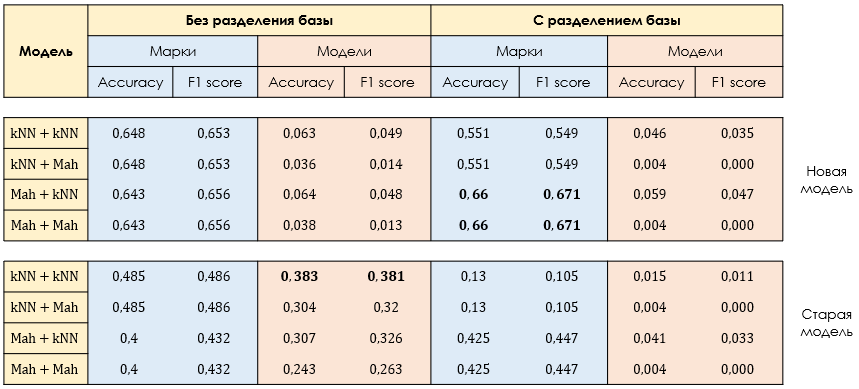

Из оценки метрик качества видно, что с определением марок автомобилей лучше всего справляется модель на основе расстояния Махаланобиса с разделением базы признаковых описаний, построенной на новой Triplet Loss модели. С определением моделей автомобилей лучше всего справляется модель на основе kNN без разделения базы признаков.

Так как качество оценки марок прямо влияет на качество оценки моделей, то имеет смысл оценить еще $4$ комбинации моделей, перебрав еще раз все алгоритмы на основе старой Triplet Loss модели.

<a id='final_model'></a>
## 8. Определение итоговой модели

**Инициализация старой Triplet Loss модели для моделей автомобилей**

In [29]:
IMAGE_SIZE = [128, 128, 1] 
device = 'cpu'
tl_models_old_model = TripletLossModelOld(
    conv_simple_features_00,
    fully_connect_modul_265,
    IMAGE_SIZE, device=device)

weights_paths = [
    'weights/4. triplet loss model - models/3. trained old/conv2Dfeatures.pt',
    'weights/4. triplet loss model - models/3. trained old/fully_connect.pt'    
]

tl_models_old_model.conv_block.load_state(weights_paths[0],
                                          map_location=device)
tl_models_old_model.fc_block.load_state(weights_paths[1],
                                        map_location=device)


Loading preset weights... Ok.

Loading preset weights... Ok.


**База признаковых описаний**

In [31]:
total_features_len = 192
features_base_joint = FeaturesBase(total_features_len)

base_filepaths = [
    'csv/train/data_marks_train_joint.csv',
    'csv/train/data_models_train_joint.csv',
    'csv/train/data_all_train_joint.csv'
]

features_base_joint.load_base(base_filepaths)

**Метрические классификаторы**

Базовые метрические модели:

In [32]:
mah_marks_model = metr_tl_cl.MarksMah(features_base_joint,
                                      keys=['View', 'Truck'])
mah_marks_model.set_mah()


knn_models_model = metr_tl_cl.ModelskNN(features_base_joint)
knn_models_model.set_knn()

mah_models_model = metr_tl_cl.ModelsMah(features_base_joint)
mah_models_model.set_mah()


knn_models_model_splited = metr_tl_cl.ModelskNN(features_base_joint,
                                              keys=['View', 'Truck'])
knn_models_model_splited.set_knn()

mah_models_model_splited = metr_tl_cl.ModelsMah(features_base_joint,
                                              keys=['View', 'Truck'])
mah_models_model_splited.set_mah()

Комбинация базовых моделей:

In [33]:
mah_knn_model = metr_tl_cl.MetricClassificationModel(
    mah_marks_model,
    knn_models_model)

mah_mah_model = metr_tl_cl.MetricClassificationModel(
    mah_marks_model,
    mah_models_model)

mah_knn_model_spltd = metr_tl_cl.MetricClassificationModel(
    mah_marks_model,
    knn_models_model_splited)

mah_mah_model_spltd = metr_tl_cl.MetricClassificationModel(
    mah_marks_model,
    mah_models_model_splited)

**Оценка качества**

In [34]:
res16 = test_classification_joint(test_ds_path,
                                  tl_mark_model, tl_models_old_model,
                                  mah_knn_model,
                                  class_view_model, class_truck_model)

print('Результаты mah + old knn:')
print(f'marks acc: {round(res16[0], 3)}')
print(f'models acc: {round(res16[1], 3)}')
print(f'marks f1: {round(res16[2], 3)}')
print(f'models f1: {round(res16[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + old knn:
marks acc: 0.66
models acc: 0.541
marks f1: 0.671
models f1: 0.544


In [35]:
res17 = test_classification_joint(test_ds_path,
                                  tl_mark_model, tl_models_old_model,
                                  mah_mah_model,
                                  class_view_model, class_truck_model)

print('Результаты mah + old mah:')
print(f'marks acc: {round(res17[0], 3)}')
print(f'models acc: {round(res17[1], 3)}')
print(f'marks f1: {round(res17[2], 3)}')
print(f'models f1: {round(res17[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + old mah:
marks acc: 0.66
models acc: 0.417
marks f1: 0.671
models f1: 0.432


In [36]:
res18 = test_classification_joint(test_ds_path,
                                  tl_mark_model, tl_models_old_model,
                                  mah_knn_model_spltd,
                                  class_view_model, class_truck_model)

print('Результаты mah + old knn с разделением:')
print(f'marks acc: {round(res18[0], 3)}')
print(f'models acc: {round(res18[1], 3)}')
print(f'marks f1: {round(res18[2], 3)}')
print(f'models f1: {round(res18[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + old knn с разделением:
marks acc: 0.66
models acc: 0.055
marks f1: 0.671
models f1: 0.046


In [37]:
res19 = test_classification_joint(test_ds_path,
                                  tl_mark_model, tl_models_old_model,
                                  mah_mah_model_spltd,
                                  class_view_model, class_truck_model)

print('Результаты mah + old mah с разделением:')
print(f'marks acc: {round(res19[0], 3)}')
print(f'models acc: {round(res19[1], 3)}')
print(f'marks f1: {round(res19[2], 3)}')
print(f'models f1: {round(res19[3], 3)}')

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Результаты mah + old mah с разделением:
marks acc: 0.66
models acc: 0.004
marks f1: 0.671
models f1: 0.0


Из результатов видно, что комбинация с kNN моделью на основе старой модели дескриптора справляется лучше остальных моделей.

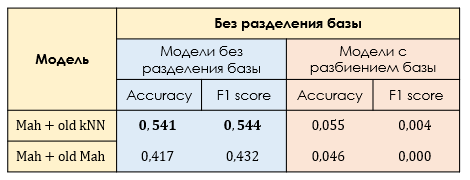

<a id='conclusion'></a>
## 9. Заключение

В результате были рассмотрены различные комбинации как моделей дескрипторов, так и метрических моделей классификации в том числе с учетом различающихся баз признаковых описаний. Если сравнивать качество распознавания с простыми классификаторами, то в результате применения более сложных моделей качество распознаваний стало заметно выше.

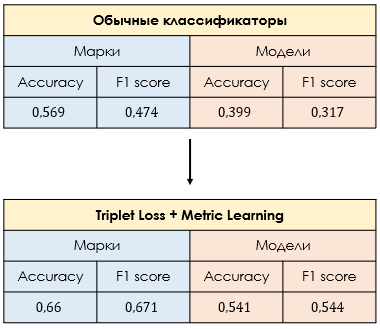